# **핸즈온 머신러닝 CHAP 7 p245~271** 

0328 월요일 과제 [개념+필사]

### **7.1 투표 기반 분류기**

정확도 80%인 분류기 여러 개를 훈련시켰다고 가정.

* **직접 투표 분류기 (hard voting)**: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 = 다수결 투표  
* 각 분류기가 약한 학습기라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음. (∵대수의 법칙)
* 앙상블 방법은 예측기가 서로 독립적일 때 최고의 성능 발휘. 이를 위해 각기 다른 알고리즘으로 학습 시켜 다른 종류의 오차를 만들면 앙상블 모델의 정확도를 향상시킬 수 있음.

In [ ]:
# moons 데이터셋 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# 투표 기반 분류기 (VotingClassifier)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting ='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [ ]:
# 각 분류기의 테스트 셋 정확도 
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.896


투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음.

* **간접 투표(soft voting)**: 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측.
* 확률이 높은 투표에 비중을 두기 때문에 직접 투표 방식보다 성능이 높음. 
* voting='soft'로 구현 가능.
* SVC의 경우 기본값에서 클래스 확률을 제공하지 않으므로 probability=True로 지정해야 함.

In [ ]:
# 간접 투표:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting ='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [ ]:
# 각 분류기의 테스트 셋 정확도 
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### **7.2 배깅과 페이스팅**

* **배깅(bagging)**: bootstrap aggregating의 약칭. 훈련 세트에서 중복을 허용하여 샘플링하는 방식.
* **페이스팅(pasting)**: 중복을 허용하지 않고 샘플링하는 방식.

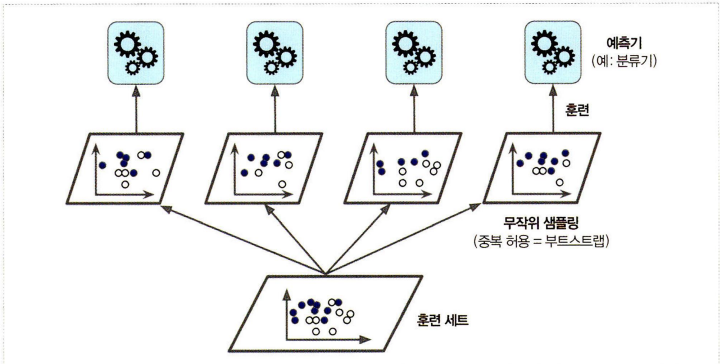

* 수집 함수는 전형적으로 분류일 때는 **통계적 최빈값**, 회귀일 때는 **평균** 계산.
* 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 큰 편향을 가짐. 수집 함수를 통과하면서 편향↓ 분산↓ 따라서 일반적으로 앙상블의 결과는 원본과 비교해 편향은 비슷하고 분산은 줄어듦. 

### 7.2.1 사이킷런의 배깅과 페이스팅

* 결정 트리 분류기 500개의 앙상블 훈련.
  * 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련 (bagging의 경우)
  * cf) 페이스팅을 사용하려면 bootstrap=False 지정.
  * n_jobs : 사이킷런이 훈련과 예측을 사용할 CPU 코어 수 지정 (-1은 가용한 모든 코어 사용 의미)
  * bagging은 pasting보다 편향이 높고 분산을 감소시킴.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1 
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 (predict_proba()함수가 있으면) 간접 투표 방식 사용.

### 7.2.2 obb 평가

* BaggingClassifier는 기본값으로 중복 허용 (bootstrap=True) → 평균적으로 각 예측기에 훈련 샘플의 63%만 샘플링 됨을 의미.
  * 선택되지 않은 훈련 샘플의 나머지 37%: **OOB(out of bag)** 샘플

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

In [ ]:
# oob 샘플에 대한 결정 함수의 값
bag_clf.oob_decision_function_

array([[0.40932642, 0.59067358],
       [0.36787565, 0.63212435],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.00540541, 0.99459459],
       [0.05494505, 0.94505495],
       [0.30481283, 0.69518717],
       [0.02      , 0.98      ],
       [0.97814208, 0.02185792],
       [0.96067416, 0.03932584],
       [0.78212291, 0.21787709],
       [0.00555556, 0.99444444],
       [0.79532164, 0.20467836],
       [0.83333333, 0.16666667],
       [0.96315789, 0.03684211],
       [0.06989247, 0.93010753],
       [0.        , 1.        ],
       [0.9800995 , 0.0199005 ],
       [0.92982456, 0.07017544],
       [0.99386503, 0.00613497],
       [0.02197802, 0.97802198],
       [0.30409357, 0.69590643],
       [0.94210526, 0.05789474],
       [1.        , 0.        ],
       [0.98974359, 0.01025641],
       [0.        , 1.        ],
       [0.99507389, 0.00492611],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.66081871, 0.33918129],
       [0.

* left: 훈련 샘플이 음성 클래스에 속할 확률
* right: 훈련 샘플이 양성 클래스에 속할 확률

### **7.3 랜덤 패치와 랜덤 서브스페이스**

* **랜덤 패치 방식(random patches method)**: 훈련 특성과 샘플을 모두 샘플링하는 것.
* **랜덤 서브스페이스 방식(random subspaces method)**: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것.

### **7.4 랜덤 포레스트**

* **랜덤 포레스트**: 일반적으로 배깅 방법(or 페이스팅)을 적용한 결정 트리 앙상블. max_samples를 훈련 세트의 크기로 지정.
  * 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾음.
  * 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성 주입. 
  * 편향 면에서 손해보지만 분산을 낮추어 성능 높임.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
# BaggingClassifier로 RandomForestClassifier와 유사하게 만든 것
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 7.4.1 엑스트라 트리

* **익스트림 랜덤 트리(extremely randomized trees) 앙상블**: 엑스트라 트리. 극단적으로 무작위한 트리의 랜덤 포레스트. 편향↑분산↓
  * ExtraTreesClassifier 사용. 

### 7.4.2 특성 중요도

* 랜덤 포레스트의 장점은 특성의 상대적 중요도 측정이 쉽다는 것.
* 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10355602666625728
sepal width (cm) 0.023711769161423
petal length (cm) 0.4398928794180449
petal width (cm) 0.4328393247542748


* 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 점수를 계산하고 중요도의 전체 합이 1이 되게 결과값 정규화.
  * feature_importances_ 변수에 저장
  * 가장 중요한 특성은 petal_length(44%)와 petal_width(43%)

### **7.5 부스팅**

**부스팅(boosting)**: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법.
  * 앞의 모델을 보완하면서 일련의 예측기 학습
  * **에이다부스트(AdaBoost)**
  * **그레이디언트 부스팅(gradient boosting)**

### 7.5.1 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 높여 새로운 예측기가 학습하기 어려운 샘플에 맞춰지도록 하는 것.

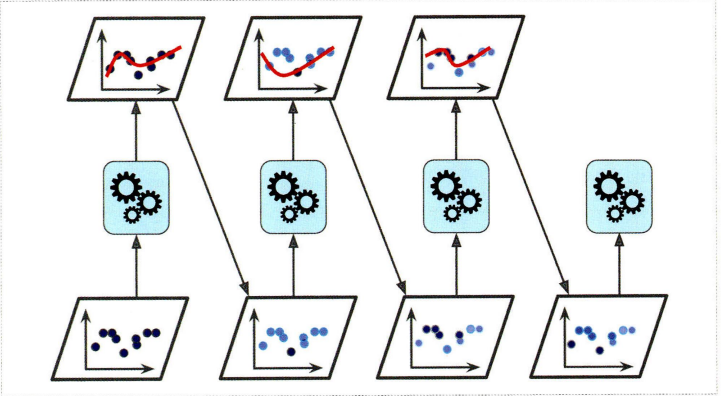

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함. \
이전 예측기가 만든 **잔여오차**에 새로운 예측기를 학습시킨다는 점이 에이다부스트와의 차이점.

In [ ]:
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
# DecisionTreeRegressor 훈련 세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

# 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

* learning_rate: 각 트리의 기여 정도 조절. 0.1과 같이 낮게 설정하면 앙상블을 훈련 세트에 학습 시키기 위해 많은 트리가 필요하지만 일반적으로 성능 향상 (**축소(shrinkage)** 규제 방법)

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)] # staged_predict(): 조기종료기법
bst_n_esimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_esimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=37)

In [38]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True) 
## warm_start=True: fit()메서드가 호출될 때 기존 트리 유지하며 훈련 추가
## subsample: 훈련 샘플의 비율 지정
## 편향 증가 + 분산 감소 -> 훈련 속도 개선 (확률적 그레이디언트 부스팅)


# 연속 5번의 반복 동안 검증 오차가 향상 되지 않으면 훈련 중지.
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators=n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # 조기 종료

In [39]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[17:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [40]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[17:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.466107
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.437302
[2]	validation_0-rmse:0.411679
[3]	validation_0-rmse:0.390773
[4]	validation_0-rmse:0.372762
[5]	validation_0-rmse:0.356098
[6]	validation_0-rmse:0.344252
[7]	validation_0-rmse:0.329503
[8]	validation_0-rmse:0.320343
[9]	validation_0-rmse:0.308766
[10]	validation_0-rmse:0.300748
[11]	validation_0-rmse:0.292352
[12]	validation_0-rmse:0.287874
[13]	validation_0-rmse:0.281003
[14]	validation_0-rmse:0.279554
[15]	validation_0-rmse:0.275342
[16]	validation_0-rmse:0.271554
[17]	validation_0-rmse:0.267938
[18]	validation_0-rmse:0.263951
[19]	validation_0-rmse:0.261874
[20]	validation_0-rmse:0.259605
[21]	validation_0-rmse:0.257494
[22]	validation_0-rmse:0.255871
[23]	validation_0-rmse:0.255366
[24]	validation_0-rmse:0.254299
[25]	validation_0-r

### **7.6 스태킹**

* **스태킹(stacking)**: stacked generalization의 약칭. 
* 마지막 예측기는 **블렌더** 또는 **메타 학습기**라 칭함.
* 블렌더를 학습시키는 일반적인 방법은 **홀드 아웃**세트 사용.
  * 스태킹: 아웃 오브 폴드 예측 사용
  * 블렌딩: 홀드 아웃 세트 사용
  * 그러나 많은 사람들이 두 용어를 같은 의미로 사용함.
* 사이킷런은 스태킹을 직접 지원하지 않음.

